In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift
import time
import glob as glob

In [3]:
images = [cv.imread(file) for file in glob.glob("*")]  #, cv.IMREAD_GRAYSCALE

# Punto 1

In [4]:
def create_gauss_filter(k_size, h, w, sigma = 10):
      
    if w and h is not None:
        assert w % 2 == 1 and h % 2 == 1, f"{w} or {h} aren't odd number"
        ax = np.linspace(-(w - 1) / 2., (w - 1) / 2., w) #(start, stop, samples)
        ay = np.linspace(-(h - 1) / 2., (h - 1) / 2., h)
        xx, yy = np.meshgrid(ax, ay)

        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
        kernel_norm = (1/sum(sum(kernel)))*kernel  
    
    else:
        ax = np.linspace(-(k_size - 1) / 2., (k_size - 1) / 2., k_size)
        xx, yy = np.meshgrid(ax, ax)

        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
        kernel_norm = (1/sum(sum(kernel)))*kernel  

    return kernel_norm

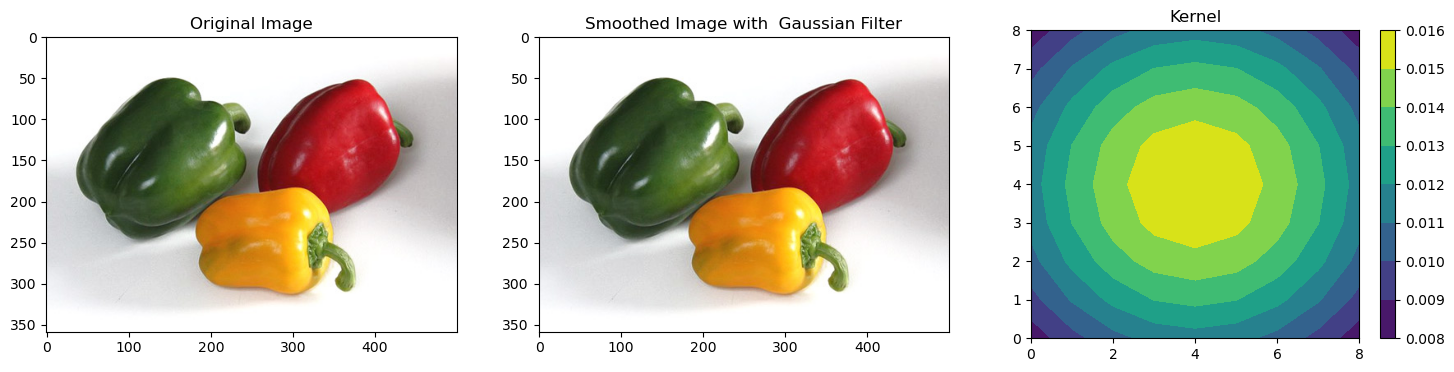

In [5]:
img = cv.imread("pimiento_morron.jpg")
#img = images[1]
# Apply the Gaussian blur function to the image
img_batch = []
for i in range(3):
    filter = create_gauss_filter(9, None, None , sigma=5)
    dst = cv.filter2D(img, -1, kernel=filter)
    img_batch.append(dst)

spec_filt = np.stack(img_batch, axis=2)


# Display the original image, filtered image and kernel
plt.figure(figsize=(18, 4))
plt.subplot(131),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)),plt.title('Original Image') 
plt.subplot(132),plt.imshow(cv.cvtColor(spec_filt, cv.COLOR_BGR2RGB)),plt.title('Smoothed Image with  Gaussian Filter')
plt.subplot(133),plt.contourf(filter),plt.title('Kernel'),plt.colorbar()
plt.show()


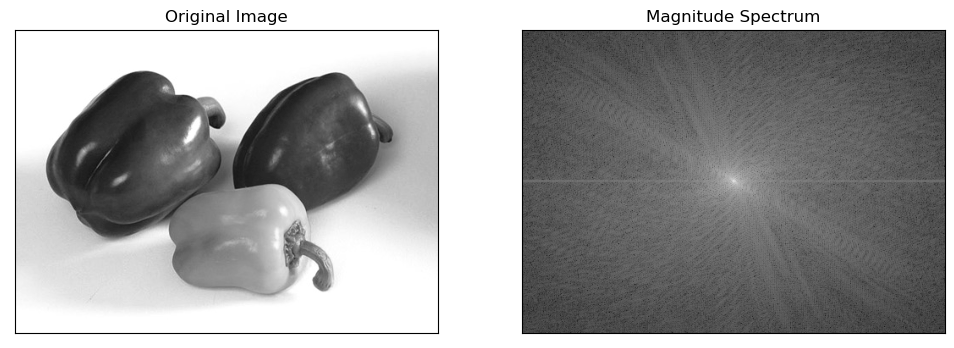

In [6]:
#img = cv.imread("pimiento_morron.jpg", cv.COLOR_BGR2RGB)
img = cv.imread("pimiento_morron.jpg", cv.IMREAD_GRAYSCALE)
#img = cv.cvtColor(images[6], cv.COLOR_BGR2GRAY)

# Compute the 2D Fourier transform of the filtered image
#f = np.fft.fft2(filtered_img)
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)

# Shift the zero-frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)

# Compute the magnitude spectrum of the filtered image
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

# Display the original image, filtered image and its magnitude spectrum
plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Genero una mascara en el dominio de Fourier y antitransformo para ver el efecto en la imagen

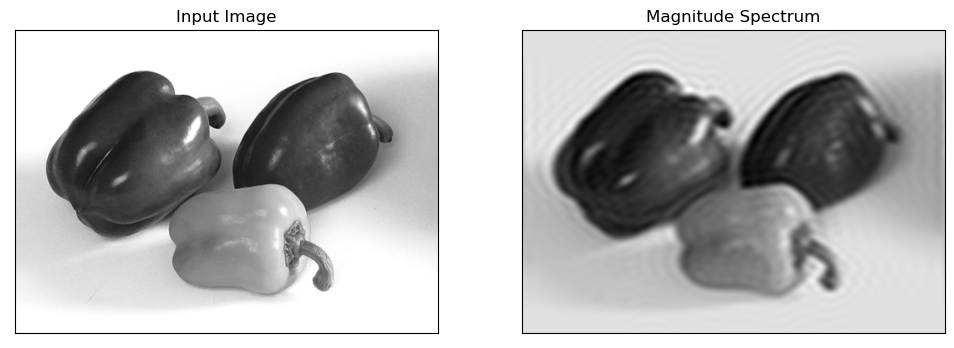

In [7]:
rows, cols = img.shape
crow,ccol = (np.around((rows/2 , cols/2),0)).astype(int)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.figure(figsize=(12, 4))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

# Punto 2

In [22]:
img = cv.imread("pimiento_morron.jpg", cv.IMREAD_GRAYSCALE)
#img = images[1]

In [19]:
def result_blur(img):

    fourier_coefficients  = np.fft.fftshift(np.fft.fft2(img))

    # compute the absolute value of all Fourier coefficients
    abs_values = np.abs(fourier_coefficients)

    # compute the maximum value among all coefficients
    maximum_value = np.max(abs_values)

    # compute the total number of coefficients that are higher than the maximum value / 1000
    total = abs_values[abs_values > maximum_value / 1000].size
    result = (total / (img.size))
    return result

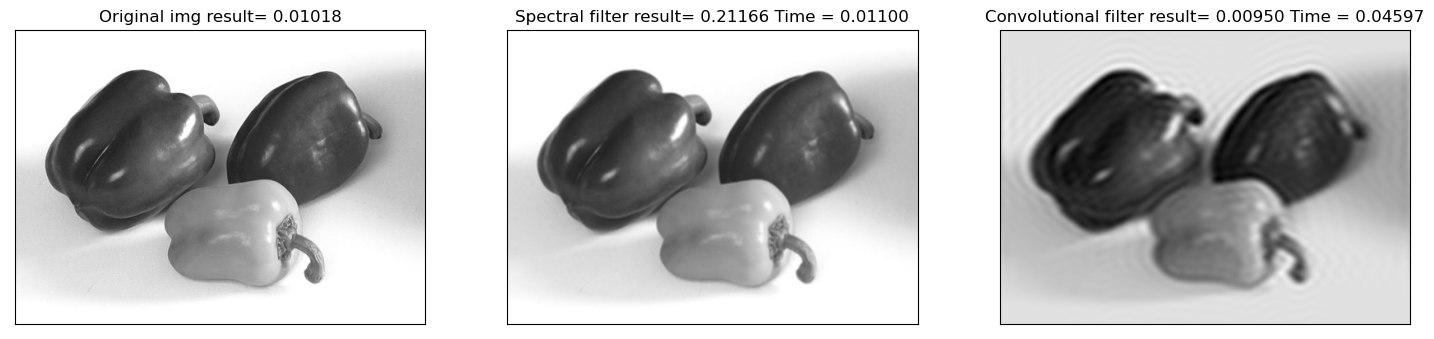

In [23]:
#img = cv.imread("pimiento_morron.jpg")
#img = cv.cvtColor(images[0], cv.COLOR_BGR2GRAY)

k_size = 3
sigma = 10

# Apply convolutional filter with Gaussian blur function
start_time = time.time()
filter = create_gauss_filter(k_size, None, None , sigma)
img_batch = []
for i in range(1):
    img_batch.append(cv.filter2D(img[:,:], -1, filter))

spec_filt = np.stack(img_batch, axis=2)
result_blur(spec_filt)
end_time = time.time()
total_time_1 = end_time-start_time

# Apply spectral filter with Gaussian blur function 
start_time = time.time()

dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
rows, cols = img.shape
crow,ccol = (np.around((rows/2 , cols/2),0)).astype(int)
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

result_blur(img_back)

end_time = time.time()
total_time_2 = end_time-start_time

# Plot the results
plt.figure(figsize=(18,10))
plt.subplot(1,3,2)
plt.title(f'Spectral filter result= {result_blur(spec_filt):.5f} Time = {total_time_1:.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(spec_filt, cv.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.title(f'Convolutional filter result= {result_blur(img_back):.5f} Time = {total_time_2:.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, 'gray')
plt.subplot(1,3,1)
plt.title(f'Original img result= {result_blur(img):.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

# Punto 3

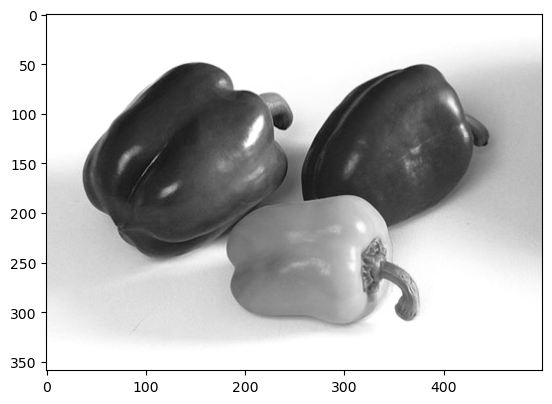

In [24]:

plt.imshow(img, cmap = 'gray')
plt.show()

Aplico uno de los metodos del paper - Gaussian derivative (GRA1)

In [12]:
def gaussian_derivative_focus_measure(img, W):
    # Compute the value of s for the given neighborhood size W
    s = W / 5
    
    # Compute the x and y partial derivatives of the image using the Sobel operator
    Gx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
    Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
    
    # Compute the focus measure for each pixel
    f = Gx**2 + Gy**2
    
    # Apply a Gaussian filter to the focus measure with the computed value of s
    f = cv.GaussianBlur(f, (W, W), s)
    
    return f

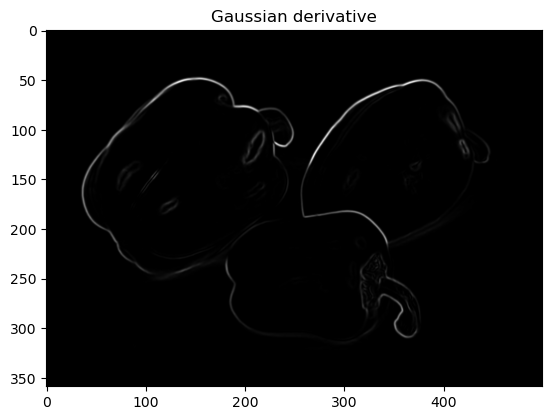

In [27]:
f = gaussian_derivative_focus_measure(img, 1)

# Display the focus measure
plt.imshow(f, cmap = 'gray'),plt.title('Gaussian derivative')
plt.show()

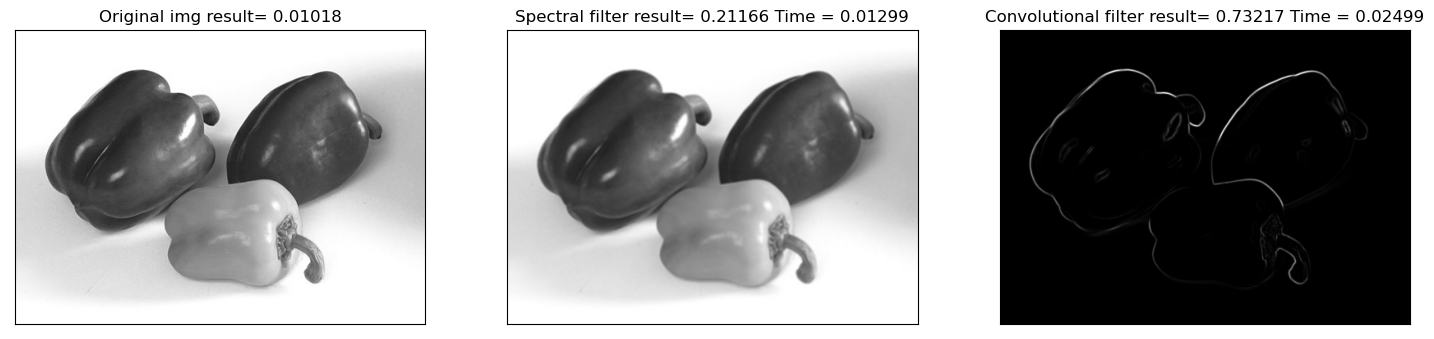

In [29]:
#img = cv.imread("pimiento_morron.jpg")
#img = cv.cvtColor(images[0], cv.COLOR_BGR2GRAY)

k_size = 3
sigma = 10

# Apply convolutional filter with Gaussian blur function
start_time = time.time()
filter = create_gauss_filter(k_size, None, None , sigma)
img_batch = []
for i in range(1):
    img_batch.append(cv.filter2D(img[:,:], -1, filter))

spec_filt = np.stack(img_batch, axis=2)
result_blur(spec_filt)
end_time = time.time()
total_time_1 = end_time-start_time

# Apply Gaussian derivative function 
start_time = time.time()

f = gaussian_derivative_focus_measure(img, 1)

result_blur(f)

end_time = time.time()
total_time_2 = end_time-start_time

# Plot the results
plt.figure(figsize=(18,10))
plt.subplot(1,3,2)
plt.title(f'Spectral filter result= {result_blur(spec_filt):.5f} Time = {total_time_1:.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(spec_filt, cv.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.title(f'Convolutional filter result= {result_blur(f):.5f} Time = {total_time_2:.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(f, 'gray')
plt.subplot(1,3,1)
plt.title(f'Original img result= {result_blur(img):.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))